In [684]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter

In [685]:
territory_lookup = pd.read_csv(r"E:\powerbidataset\AdventureWorks Territory Lookup.csv")
product_lookup = pd.read_csv(r"E:\powerbidataset\AdventureWorks Product Lookup.csv")
product_categories_lookup = pd.read_csv(r"E:\powerbidataset\AdventureWorks Product Categories Lookup.csv")
product_subcategories_lookup = pd.read_csv(r"E:\powerbidataset\AdventureWorks Product Subcategories Lookup.csv")
customer_lookup = pd.read_csv(r"E:\powerbidataset\AdventureWorks Customer Lookup.csv", encoding='1252')
calender_lookup = pd.read_csv(r"E:\powerbidataset\AdventureWorks Calendar Lookup.csv")
Sales_Data_2020 = pd.read_csv(r"E:\powerbidataset\Sales Data\AdventureWorks Sales Data 2020.csv")
Sales_Data_2021 = pd.read_csv(r"E:\powerbidataset\Sales Data\AdventureWorks Sales Data 2021.csv")
Sales_Data_2022 = pd.read_csv(r"E:\powerbidataset\Sales Data\AdventureWorks Sales Data 2022.csv")
returns_data = pd.read_csv(r"E:\powerbidataset\AdventureWorks Returns Data.csv")
sales_data = pd.concat([Sales_Data_2020,Sales_Data_2021,Sales_Data_2022],ignore_index=True)

Transforming Data

In [686]:
# Convert Date Columns to Datetime Format
sales_data['OrderDate']=pd.to_datetime(sales_data['OrderDate'])
returns_data['ReturnDate']=pd.to_datetime(returns_data['ReturnDate'])
calender_lookup['Date']=pd.to_datetime(calender_lookup['Date'])
customer_lookup['BirthDate'] = pd.to_datetime(customer_lookup['BirthDate'])

In [687]:
# Drop the 'ProductSize' column if it exists
product_lookup.drop('ProductSize', axis=1, inplace=True, errors='ignore')

# Create a new 'SKUType' column by combining the first two parts of 'ProductSKU'
product_lookup['SKUType'] = product_lookup['ProductSKU'].str.split('-').str[0] + "-" + product_lookup['ProductSKU'].str.split('-').str[1]

# Round 'ProductCost' and 'ProductPrice' to 2 decimal places for consistency
product_lookup['ProductCost'] = product_lookup['ProductCost'].round(2)
product_lookup['ProductPrice'] = product_lookup['ProductPrice'].round(2)

# Replace '0' with 'NA' in the 'ProductStyle' column to indicate missing data
product_lookup['ProductStyle'] = product_lookup['ProductStyle'].replace('0', 'NA')

In [688]:
# Convert 'CustomerKey' to numeric, coercing errors to NaN
customer_lookup['CustomerKey'] = pd.to_numeric(customer_lookup['CustomerKey'], errors='coerce')

# Drop rows where 'CustomerKey' is NaN
customer_lookup.dropna(subset=['CustomerKey'], axis=0, inplace=True)

# Convert 'CustomerKey' to integer type after cleaning
customer_lookup['CustomerKey'] = customer_lookup['CustomerKey'].astype('int64')


In [689]:
# Capitalize the first letter of 'Prefix', 'FirstName', and 'LastName'
customer_lookup[['Prefix', 'FirstName', 'LastName']] = customer_lookup[['Prefix', 'FirstName', 'LastName']].apply(lambda x: x.str.title())

# Create a 'FullName' column by concatenating 'Prefix', 'FirstName', and 'LastName'
customer_lookup['FullName'] = customer_lookup['Prefix'] + " " + customer_lookup['FirstName'] + " " + customer_lookup['LastName']

# Extract the domain name from 'EmailAddress' and format it, replacing hyphens with spaces
customer_lookup['DomainName'] = customer_lookup['EmailAddress'].apply(lambda x: x[x.find('@')+1:x.find('.')].title().replace('-', ' '))


In [690]:
# Apply a 10% discount to 'ProductPrice' and round iy to 2 decimal places
product_lookup['DiscountPrice'] = (product_lookup['ProductPrice'] * 0.9).round(2)


Calendar Lookup Data with Date-related Information

In [691]:
# Add the name of the day for each date
calender_lookup['DayName'] = calender_lookup['Date'].dt.day_name()

# Calculate the start of the week for each date
calender_lookup['StartofWeek'] = calender_lookup['Date'] - pd.to_timedelta(calender_lookup['Date'].dt.isocalendar().day, unit='d')

# Determine the start of the month for each date
calender_lookup['StartofMonth'] = calender_lookup['Date'].dt.to_period('M').dt.start_time

# Determine the start of the quarter for each date
calender_lookup['StartofQuarter'] = calender_lookup['Date'].dt.to_period('Q').dt.start_time

# Add the name of the month for each date
calender_lookup['MonthName'] = calender_lookup['Date'].dt.month_name()

# Extract the month number for each date
calender_lookup['MonthNumber'] = calender_lookup['Date'].dt.month

# Determine the start of the year for each date
calender_lookup['StartofYear'] = calender_lookup['Date'].dt.to_period('Y').dt.start_time

# Extract the year from each date
calender_lookup['Year'] = calender_lookup['Date'].dt.year

# Ensure that 'StartofWeek', 'StartofMonth', 'StartofQuarter', and 'StartofYear' are in datetime format
calender_lookup[['StartofWeek', 'StartofMonth', 'StartofQuarter', 'StartofYear']] = calender_lookup[['StartofWeek', 'StartofMonth', 'StartofQuarter', 'StartofYear']].apply(pd.to_datetime)


Categorize order quantities

In [692]:
def quantity_type(x):
    if x == 1:
        return "Single Item"
    elif x > 1:
        return "Multiple Item"
    else:
        return "Others"

# create a 'QuantityType' column
sales_data['QuantityType'] = sales_data['OrderQuantity'].apply(quantity_type)

In [693]:
# create a 'Parent' column based on 'TotalChildren' column
customer_lookup['Parent'] = customer_lookup['TotalChildren'].apply(lambda x: "Yes" if x > 0 else "No")

Categorize product prices into price points

In [694]:
def price_point(x):
    if x > 500:
        return "High"
    elif x > 100:
        return "Mid-Range"
    else:
        return "Low"

# create a 'PricePoint' column
product_lookup['PricePoint'] = product_lookup['ProductPrice'].apply(price_point)


Categorize customers based on their parent status and annual income

In [695]:
def customer_priority(x):
    if x['Parent'] == "Yes" and x['AnnualIncome'] > 100000:
        return "Priority"
    else:
        return "Standard"

# create a 'CustomerPriority' column
customer_lookup['CustomerPriority'] = customer_lookup.apply(customer_priority, axis=1)


Categorize income levels

In [696]:
def income_level(x):
    if x >= 150000:
        return "Very High"
    elif x >= 100000:
        return "High"
    elif x >= 50000:
        return "Average"
    else:
        return "Low"

# create an 'IncomeLevel' column
customer_lookup['IncomeLevel'] = customer_lookup['AnnualIncome'].apply(income_level)


Categorize education levels

In [697]:
def education_category(x):
    if x in ["High School", "Partial High School"]:
        return "High School"
    elif x in ["Bachelors", "Partial College"]:
        return "Undergrad"
    elif x == "Graduate Degree":
        return "Graduate"
    else:
        return ""

# create an 'EducationCategory' column
customer_lookup['EducationCategory'] = customer_lookup['EducationLevel'].apply(education_category)


In [698]:
calender_lookup['MonthShort']= calender_lookup['Date'].dt.strftime('%b').str.upper()

SKU category from the 'ProductSKU'

In [699]:
def sku_category(x):
    x = x[:x.find('-')]
    return x

# create an 'SkuCategory' column
product_lookup['SkuCategory'] = product_lookup['ProductSKU'].apply(sku_category)


categorize days as 'Weekend' or 'Weekday'

In [700]:
# Add a column for the day of the week based on the ISO calendar
calender_lookup['DayofWeek'] = calender_lookup['Date'].dt.isocalendar().day

def week_end(x):
    if x in [6, 7]:
        return "Weekend"
    else:
        return "Weekday"

# create a 'Weekend' column
calender_lookup['Weekend'] = calender_lookup['DayofWeek'].apply(week_end)


In [701]:
customer_lookup['BirthYear']=customer_lookup['BirthDate'].dt.year

function for units formatting (m-millions,b-billions,k-thousands)

In [702]:
def display_unit_formatter(value, decimal_places=1):
    if value >= 1_000_000_000:
        formatted_value = value / 1_000_000_000
        suffix = 'B'
    elif value >= 1_000_000:
        formatted_value = value / 1_000_000
        suffix = 'M'
    elif value >= 1_000:
        formatted_value = value / 1_000
        suffix = 'K'
    else:
        return str(value)

    return f"{formatted_value:.{decimal_places}f} {suffix}"



Visualizations

Total Revenue

In [703]:
# Merge sales_data with product_lookup to create a sales_product_table
sales_product_table = pd.merge(sales_data, product_lookup, how='left', on='ProductKey')

# Calculate the total revenue by multiplying 'ProductPrice' by 'OrderQuantity' and summing the result
total_revenue = (sales_product_table['ProductPrice'] * sales_product_table['OrderQuantity']).sum()

# Format the total revenue using display_unit_formatter with 1 decimal place
formatted_revenue = display_unit_formatter(total_revenue, decimal_places=1)

print(formatted_revenue)

24.9 M


Total Profit

In [704]:
# Calculate the total cost by multiplying 'ProductCost' by 'OrderQuantity' and summing the result
total_cost = (sales_product_table['ProductCost'] * sales_product_table['OrderQuantity']).sum()

# Calculate total profit by subtracting total cost from total revenue
total_profit = total_revenue - total_cost

# Format the total profit using display_unit_formatter with 1 decimal place
formatted_profit = display_unit_formatter(total_profit, decimal_places=1)

print(formatted_profit)

10.5 M


Total no: of Unique Orders

In [705]:
# Calculate the total number of unique orders
total_orders = sales_data['OrderNumber'].nunique()
total_orders


25164

Return Rate

In [706]:
# Calculate the total quantity sold from sales_data
quantity_sold = sales_data['OrderQuantity'].sum()

# Calculate the total quantity returned from returns_data
quantity_returned = returns_data['ReturnQuantity'].sum()

# Calculate the return rate as a percentage and format it to 2 decimal places
return_rate = f"{(quantity_returned / quantity_sold * 100):.2f}%"

print(return_rate)

2.17%


Average Revenue Per Customer

In [707]:
# Calculate revenue for each transaction in the sales_product_table
sales_product_table['Revenue'] = sales_product_table['ProductPrice'] * sales_product_table['OrderQuantity']

# Calculate the average revenue per customer
average_revenue_per_customer = (
    sales_product_table
    .groupby('CustomerKey')['Revenue']
    .agg(['sum'])
    .reset_index()['sum']
    .mean()
)

# Round the average revenue per customer to 2 decimal places
average_revenue_per_customer_rounded = average_revenue_per_customer.round(2)
average_revenue_per_customer_rounded


1430.56

Total Customers (Active Customers)

In [708]:
# Calculate the total number of unique active customers
active_customers = sales_data['CustomerKey'].nunique()
print(active_customers)


17416


Line Chart - Revenue Trends: Yearly,Quarterly and Monthly

In [709]:
# Merge sales_product_table with calender_lookup to include calendar information
sales_product_calender_table = pd.merge(
    sales_product_table, 
    calender_lookup, 
    how='left', 
    left_on='OrderDate', 
    right_on='Date'
)

# Calculate total revenue by year
yearly_revenue = (
    sales_product_calender_table
    .groupby('Year')['Revenue']
    .sum()
    .reset_index()
)

# Calculate total revenue by quarter
quarterly_revenue = (
    sales_product_calender_table
    .groupby('StartofQuarter')['Revenue']
    .sum()
    .reset_index()
)

# Calculate total revenue by month
monthly_revenue = (
    sales_product_calender_table
    .groupby('StartofMonth')['Revenue']
    .sum()
    .reset_index()
)


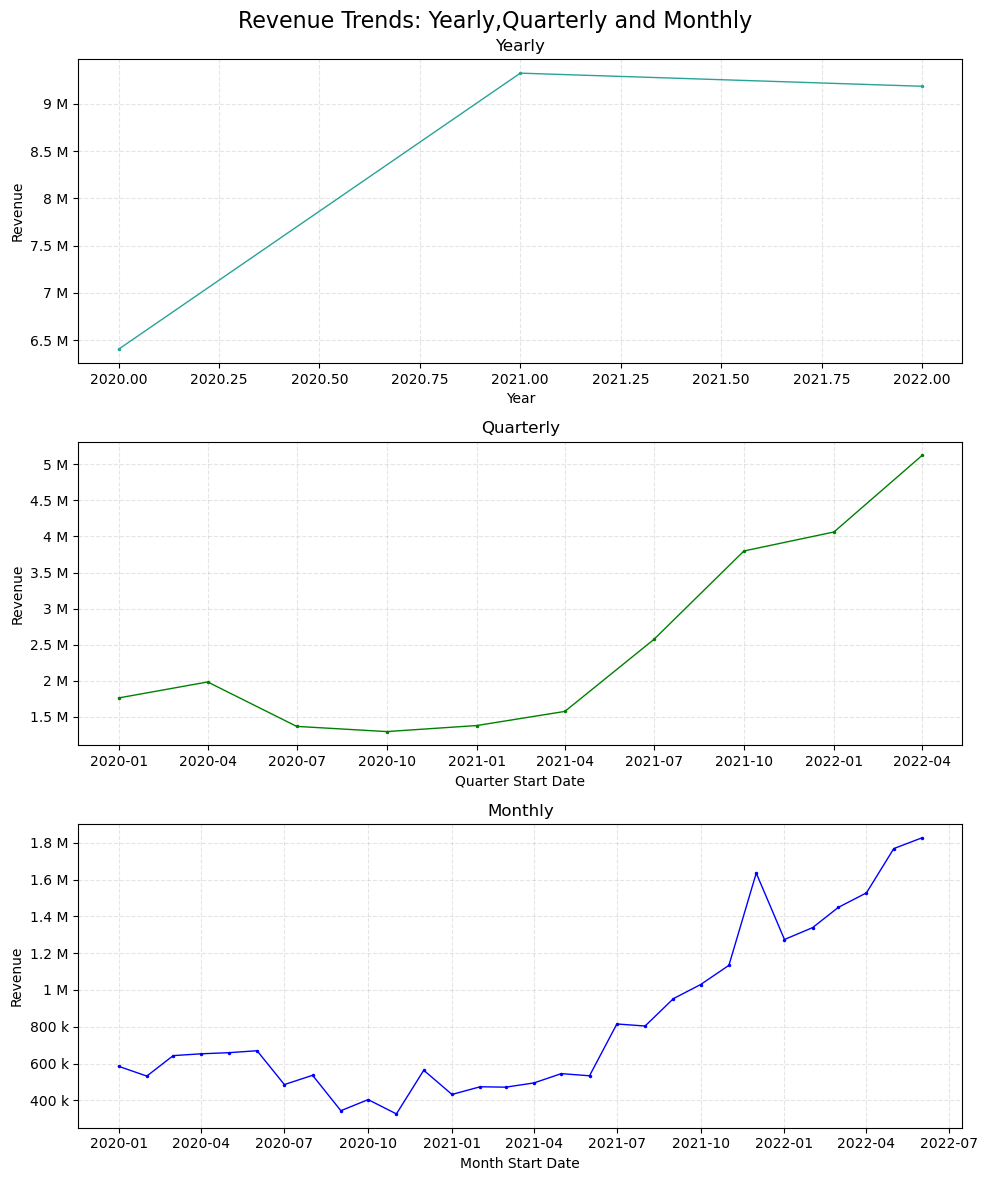

In [710]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot yearly revenue
ax[0].plot(yearly_revenue.iloc[:, 0], yearly_revenue.iloc[:, 1], color='#28A397', linewidth=1, marker='.', markersize=3)
ax[0].set_title('Yearly')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Revenue')
ax[0].yaxis.set_major_formatter(EngFormatter())
ax[0].grid(color='grey', alpha=0.2, linestyle='dashed')

# Plot quarterly revenue
ax[1].plot(quarterly_revenue.iloc[:, 0], quarterly_revenue.iloc[:, 1], color='g', linewidth=1, marker='.', markersize=3)
ax[1].set_title('Quarterly')
ax[1].set_xlabel('Quarter Start Date')
ax[1].set_ylabel('Revenue')
ax[1].yaxis.set_major_formatter(EngFormatter())
ax[1].grid(color='grey', alpha=0.2, linestyle='dashed')

# Plot monthly revenue
ax[2].plot(monthly_revenue.iloc[:, 0], monthly_revenue.iloc[:, 1], color='b', linewidth=1, marker='.', markersize=3)
ax[2].set_title('Monthly')
ax[2].set_xlabel('Month Start Date')
ax[2].set_ylabel('Revenue')
ax[2].yaxis.set_major_formatter(EngFormatter())
ax[2].grid(color='grey', alpha=0.2, linestyle='dashed')

plt.suptitle('Revenue Trends: Yearly,Quarterly and Monthly', fontsize=16)
plt.tight_layout()
plt.show()

Line Chart - Customers per year,month,week and day

In [711]:
# Calculate the number of unique customers per year
customersperyear = (
    sales_product_calender_table
    .groupby('StartofYear')['CustomerKey']
    .nunique()
    .reset_index()
)

# Calculate the number of unique customers per month
customerspermonth = (
    sales_product_calender_table
    .groupby('StartofMonth')['CustomerKey']
    .nunique()
    .reset_index()
)

# Calculate the number of unique customers per week
customersperweek = (
    sales_product_calender_table
    .groupby('StartofWeek')['CustomerKey']
    .nunique()
    .reset_index()
)

# Calculate the number of unique customers per day
customersperday = (
    sales_product_calender_table
    .groupby('Date')['CustomerKey']
    .nunique()
    .reset_index()
)


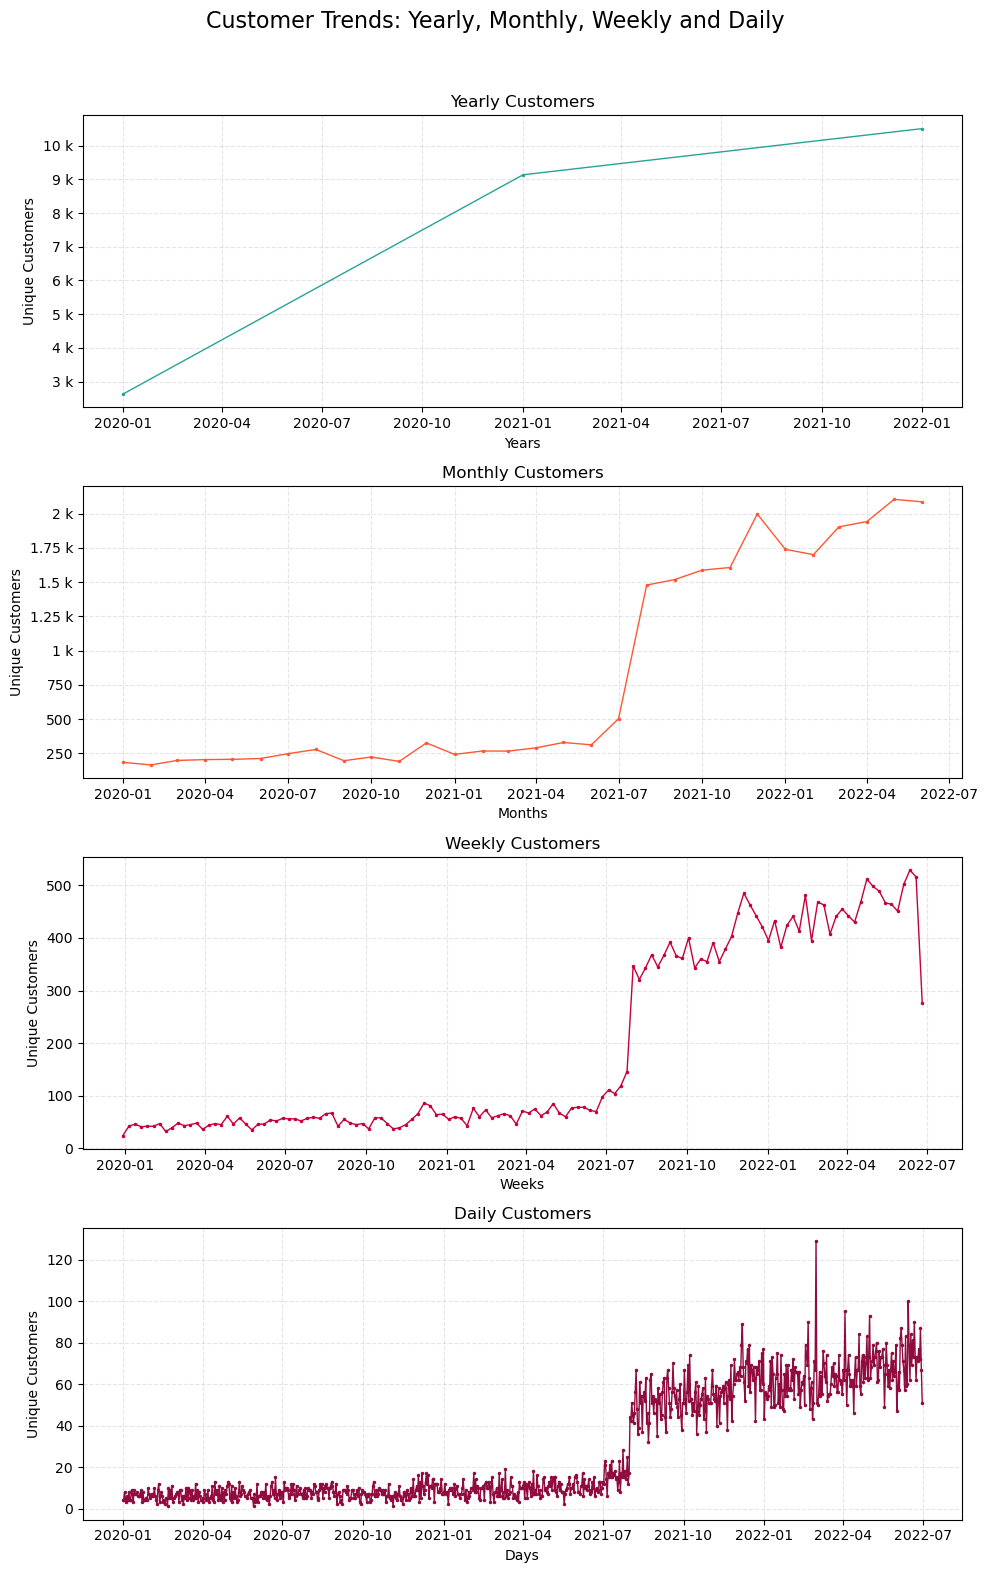

In [712]:
fig, ax = plt.subplots(4, 1, figsize=(10, 16))

# Plot customers per year
ax[0].plot(customersperyear.iloc[:, 0], customersperyear.iloc[:, 1], color='#28A397', linewidth=1, marker='.', markersize=3)
ax[0].set_title('Yearly Customers')
ax[0].set_xlabel('Years')
ax[0].set_ylabel('Unique Customers')
ax[0].yaxis.set_major_formatter(EngFormatter())
ax[0].grid(color='grey', alpha=0.2, linestyle='dashed')

# Plot customers per month
ax[1].plot(customerspermonth.iloc[:, 0], customerspermonth.iloc[:, 1], color='#FF5733', linewidth=1, marker='.', markersize=3)
ax[1].set_title('Monthly Customers')
ax[1].set_xlabel('Months')
ax[1].set_ylabel('Unique Customers')
ax[1].yaxis.set_major_formatter(EngFormatter())
ax[1].grid(color='grey', alpha=0.2, linestyle='dashed')

# Plot customers per week
ax[2].plot(customersperweek.iloc[:, 0], customersperweek.iloc[:, 1], color='#C70039', linewidth=1, marker='.', markersize=3)
ax[2].set_title('Weekly Customers')
ax[2].set_xlabel('Weeks')
ax[2].set_ylabel('Unique Customers')
ax[2].yaxis.set_major_formatter(EngFormatter())
ax[2].grid(color='grey', alpha=0.2, linestyle='dashed')

# Plot customers per day
ax[3].plot(customersperday.iloc[:, 0], customersperday.iloc[:, 1], color='#900C3F', linewidth=1, marker='.', markersize=3)
ax[3].set_title('Daily Customers')
ax[3].set_xlabel('Days')
ax[3].set_ylabel('Unique Customers')
ax[3].yaxis.set_major_formatter(EngFormatter())
ax[3].grid(color='grey', alpha=0.2, linestyle='dashed')
plt.suptitle('Customer Trends: Yearly, Monthly, Weekly and Daily', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

Last month revenue vs previous month revenue

In [713]:
# Filter data for the last month based on the maximum 'StartofMonth'
last_month_revenue = (
    sales_product_calender_table[sales_product_calender_table['StartofMonth'] == max(sales_product_calender_table['StartofMonth'])]
    .groupby(['StartofMonth'])['Revenue']
    .sum()
    .reset_index()
)

# Format the revenue for the last month using display_unit_formatter with 2 decimal places
formatted_last_month_revenue = display_unit_formatter(last_month_revenue['Revenue'].iloc[0], decimal_places=2)

print(formatted_last_month_revenue)


1.83 M


In [714]:
# Calculate the start date of the previous month
previous_month = max(sales_product_calender_table['StartofMonth']) - pd.DateOffset(months=1)

# Filter data for the previous month
previous_month_revenue = (
    sales_product_calender_table[sales_product_calender_table['StartofMonth'] == previous_month]
    .groupby(['StartofMonth'])['Revenue']
    .sum()
    .reset_index()
)

# Format the revenue for the previous month using display_unit_formatter with 2 decimal places
formatted_previous_month_revenue = display_unit_formatter(previous_month_revenue['Revenue'].iloc[0], decimal_places=2)

print(formatted_previous_month_revenue)


1.77 M


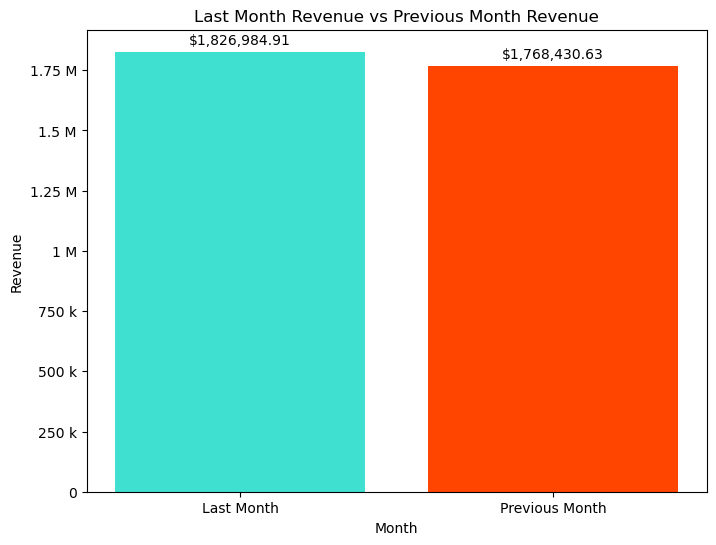

In [715]:
last_revenue = last_month_revenue['Revenue'].iloc[0]
previous_revenue = previous_month_revenue['Revenue'].iloc[0]
plt.figure(figsize=(8, 6))
bars = plt.bar(['Last Month', 'Previous Month'],
               [last_revenue, previous_revenue],
               color=['#40E0D0', '#FF4500'])

plt.bar_label(bars, labels=[f'${last_revenue:,.2f}', f'${previous_revenue:,.2f}'], padding=3)
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.title('Last Month Revenue vs Previous Month Revenue')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.show()

last month orders vs previous month orders

In [716]:
# Calculate the number of unique orders for the last month
last_month_orders = (
    sales_product_calender_table[sales_product_calender_table['StartofMonth'] == max(sales_product_calender_table['StartofMonth'])]
    .groupby(['StartofMonth'])['OrderNumber']
    .nunique()
    .reset_index()
)

# Output the number of unique orders for the current month
current_month_orders_count = last_month_orders['OrderNumber'].iloc[0]
current_month_orders_count


2146

In [717]:
# Calculate the number of unique orders for the previous month
previous_month_orders = (
    sales_product_calender_table[sales_product_calender_table['StartofMonth'] == previous_month]
    .groupby(['StartofMonth'])['OrderNumber']
    .nunique()  # Count unique orders for the previous month
    .reset_index()  # Reset index to convert GroupBy object to DataFrame
)

# Output the number of unique orders for the previous month
previous_month_orders_count = previous_month_orders['OrderNumber'].iloc[0]
previous_month_orders_count


2165

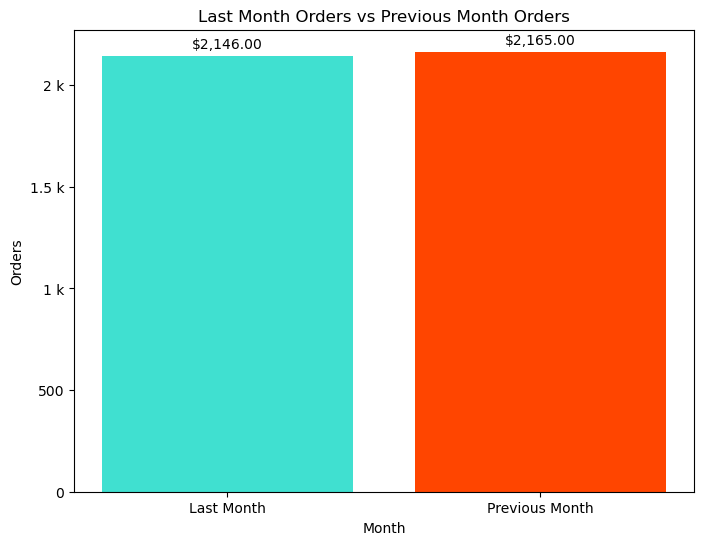

In [718]:
last_orders = last_month_orders['OrderNumber'].iloc[0]
previous_orders = previous_month_orders['OrderNumber'].iloc[0]
plt.figure(figsize=(8, 6))
bars = plt.bar(['Last Month', 'Previous Month'],
               [last_orders, previous_orders],
               color=['#40E0D0', '#FF4500'])

plt.bar_label(bars, labels=[f'${last_orders:,.2f}', f'${previous_orders:,.2f}'], padding=3)
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.title('Last Month Orders vs Previous Month Orders')
plt.ylabel('Orders')
plt.xlabel('Month')
plt.show()

last month returns vs previous month returns

In [719]:
# Merge returns_data with calender_lookup to include calendar information for returns
returns_calender_table = pd.merge(
    returns_data, 
    calender_lookup, 
    how='left', 
    left_on='ReturnDate', 
    right_on='Date'
)

In [720]:
# Calculate the number of returns for the current month
last_month_returns = (
    returns_calender_table[returns_calender_table['StartofMonth'] == max(returns_calender_table['StartofMonth'])]
    .groupby(['StartofMonth'])['ReturnQuantity']
    .count()
    .reset_index()
)

# Output the number of returns for the current month
last_month_returns['ReturnQuantity'].iloc[0]


166

In [721]:
# Calculate the number of returns for the previous month
previous_month_returns = (
    returns_calender_table[returns_calender_table['StartofMonth'] == previous_month]
    .groupby(['StartofMonth'])['ReturnQuantity']
    .count()
    .reset_index()
)

# Output the number of returns for the previous month
previous_month_returns['ReturnQuantity'].iloc[0]


169

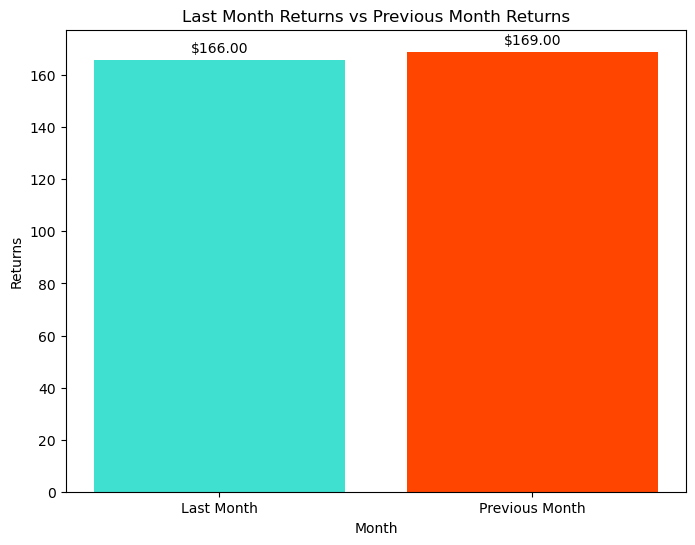

In [722]:
last_returns = last_month_returns['ReturnQuantity'].iloc[0]
previous_returns = previous_month_returns['ReturnQuantity'].iloc[0]
plt.figure(figsize=(8, 6))
bars = plt.bar(['Last Month', 'Previous Month'],
               [last_returns, previous_returns],
               color=['#40E0D0', '#FF4500'])

plt.bar_label(bars, labels=[f'${last_returns:,.2f}', f'${previous_returns:,.2f}'], padding=3)
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.title('Last Month Returns vs Previous Month Returns')
plt.ylabel('Returns')
plt.xlabel('Month')
plt.show()


Orders per category

In [723]:
# Merge sales_data with product_lookup, product_subcategories_lookup, and product_categories_lookup to include product category information
sales_pro_prosub_procat = (
    sales_data
    .merge(product_lookup, how='left', on='ProductKey')  # Merge with product_lookup to get product details
    .merge(product_subcategories_lookup, how='left', on='ProductSubcategoryKey')  # Merge with product_subcategories_lookup to get subcategory details
    .merge(product_categories_lookup, how='left', on='ProductCategoryKey')  # Merge with product_categories_lookup to get category details
)

# Calculate the number of unique orders by product category
orders_by_category = (
    sales_pro_prosub_procat
    .groupby('CategoryName')['OrderNumber']
    .nunique()
    .reset_index()
    .sort_values(by='OrderNumber', ascending=True) 
)
orders_by_category


,CategoryName,OrderNumber
2,Clothing,6976
1,Bikes,13929
0,Accessories,16983


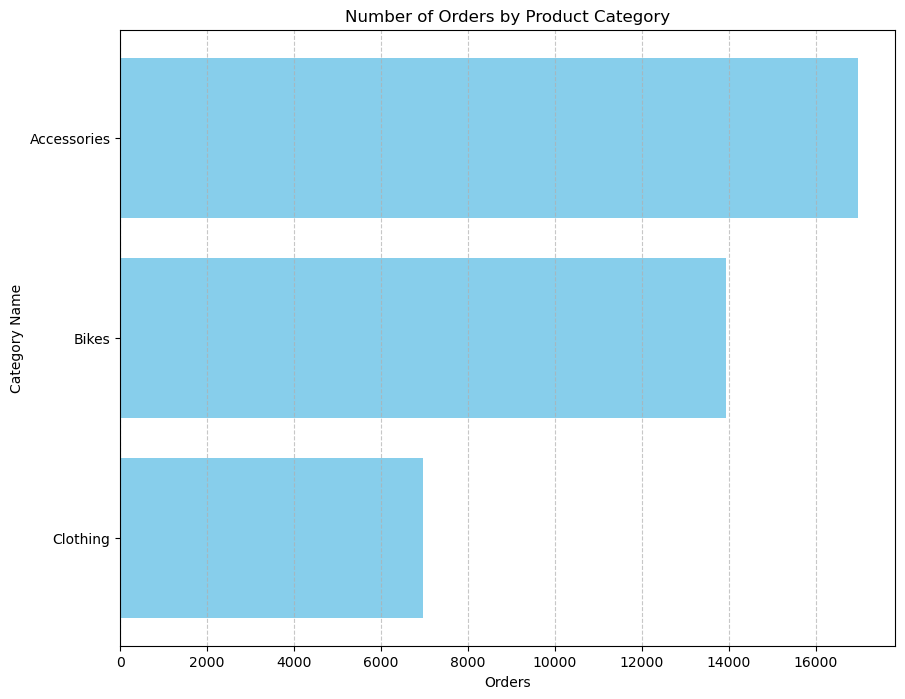

In [724]:
plt.figure(figsize=(10, 8))
plt.barh(orders_by_category['CategoryName'], orders_by_category['OrderNumber'], color='skyblue')
plt.xlabel('Orders')
plt.ylabel('Category Name')
plt.title('Number of Orders by Product Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

orders per income level

In [725]:
# Merge sales_data with customer_lookup to include customer information
sales_customer = pd.merge(
    sales_data, 
    customer_lookup, 
    how='left', 
    on='CustomerKey'
)

# Calculate the number of unique orders by income level
order_per_income = (
    sales_customer
    .groupby('IncomeLevel')['OrderNumber']
    .nunique()
    .reset_index()
)
order_per_income


,IncomeLevel,OrderNumber
0,Average,11600
1,High,2827
2,Low,10266
3,Very High,471


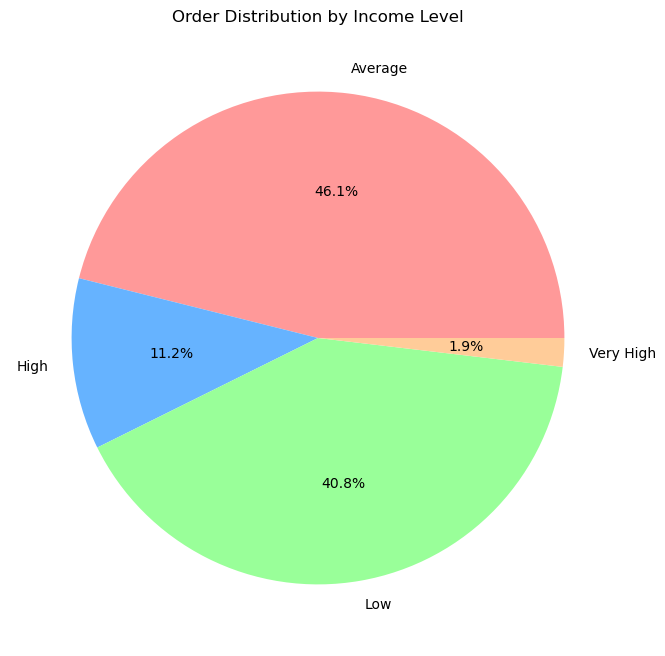

In [726]:
plt.figure(figsize=(8, 8))
plt.pie(order_per_income['OrderNumber'], labels=order_per_income['IncomeLevel'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Order Distribution by Income Level')
plt.show()

orders distribution per occupation

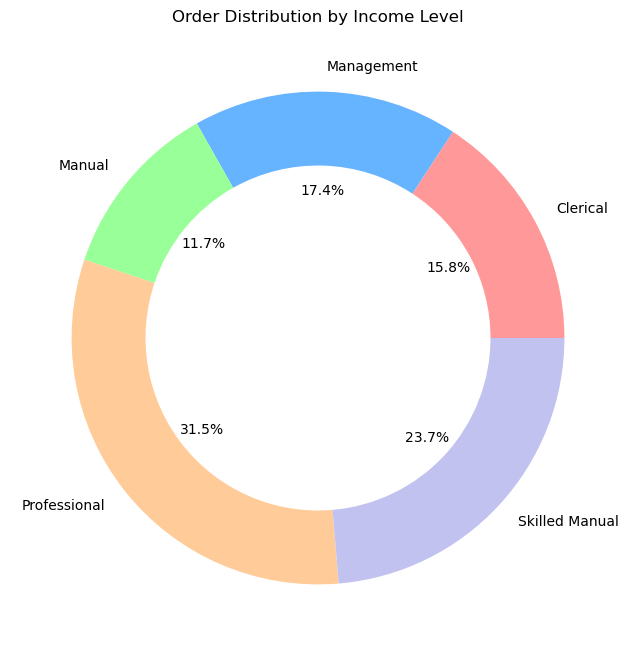

In [727]:
order_per_occupation=sales_customer.groupby('Occupation')['OrderNumber'].nunique().reset_index()
plt.figure(figsize=(8, 8))
plt.pie(order_per_occupation['OrderNumber'], labels=order_per_occupation['Occupation'], autopct='%1.1f%%', colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'],wedgeprops={'width': 0.3})
plt.title('Order Distribution by Income Level')
plt.show()

orders,revenue,returnrate per product (top 10)

In [728]:
# Calculate revenue for each product
op = sales_pro_prosub_procat.copy()
op['Revenue'] = op['OrderQuantity'] * op['ProductPrice']

# Aggregate data to get unique orders, total revenue, and total order quantity per product
result = (
    op.groupby(['ProductName', 'ProductKey'])[['OrderNumber', 'Revenue', 'OrderQuantity']]
    .agg({
        'OrderNumber': 'nunique',
        'Revenue': 'sum',
        'OrderQuantity': 'sum'
    })
    .reset_index()
)

# Merge returns data with product lookup to include product details for returns
product_returns_table = pd.merge(
    returns_data, 
    product_lookup, 
    how='left', 
    on='ProductKey'
)

# Calculate total return quantity for each product
op1 = (
    product_returns_table
    .groupby('ProductKey')['ReturnQuantity']
    .sum()
    .reset_index()
)

# Merge result DataFrame with return quantity data
rt = result.merge(op1, how='left', on='ProductKey')

# Calculate return rate as a percentage
rt['ReturnRate'] = (
    (rt['ReturnQuantity'] / rt['OrderQuantity'] * 100)
    .round(2)
    .astype(str) + '%'
)

# Select top 10 products with the highest number of unique orders
top_products = (
    rt[['ProductName', 'OrderNumber', 'Revenue', 'ReturnRate']]
    .sort_values(by='OrderNumber', ascending=False)
    .iloc[0:10]
    .reset_index(drop=True)
)
top_products


,ProductName,OrderNumber,Revenue,ReturnRate
0,Water Bottle - 30 oz.,3983,39755.33,1.95%
1,Patch Kit/8 Patches,2952,13506.42,1.61%
2,Mountain Tire Tube,2846,28333.22,1.64%
3,Road Tire Tube,2173,17264.73,1.55%
4,"Sport-100 Helmet, Red",2099,73444.01,3.33%
5,AWC Logo Cap,2062,35864.64,1.11%
6,"Sport-100 Helmet, Blue",1995,67111.80,3.31%
7,Fender Set - Mountain,1975,87040.80,1.36%
8,"Sport-100 Helmet, Black",1940,65261.60,2.68%
9,Mountain Bottle Cage,1896,38061.90,2.02%


orders,revenue per customers (top 30)

In [729]:
# Merge sales data with customer information
cus = pd.merge(
    sales_product_table, 
    customer_lookup, 
    how='left', 
    on='CustomerKey'
)

# Calculate revenue for each order
cus['Revenue'] = cus['ProductPrice'] * cus['OrderQuantity']

# Aggregate data to get the number of unique orders and total revenue per customer
top_customers = (
    cus.groupby(['CustomerKey', 'FullName'])
    .agg({
        'OrderNumber': 'nunique',
        'Revenue': 'sum'
    })
    .reset_index()
    .sort_values(by='OrderNumber', ascending=False)
    .iloc[0:30]
    .reset_index(drop=True)
)

# Output the top 30 customers
top_customers


,CustomerKey,FullName,OrderNumber,Revenue
0,11330,Mr. Ryan Thompson,26,1596.61
1,11331,Mrs. Samantha Jenkins,26,1739.55
2,11223,Mrs. Hailey Patterson,26,1615.65
3,11091,Mr. Dalton Perez,26,1513.14
4,11300,Mr. Fernando Barnes,26,1838.99
5,11200,Mr. Jason Griffin,25,1613.87
6,11185,Mrs. Ashley Henderson,25,1716.73
7,11287,Mr. Henry Garcia,24,1442.94
8,11262,Mrs. Jennifer Simmons,24,1464.79
9,11566,Ms. April Shan,24,1424.45


subcategory with the highest orders

In [730]:
# Group by product subcategory and calculate the number of unique orders
top_subcategory_product = (
    op.groupby('SubcategoryName')['OrderNumber']
    .nunique()
    .reset_index()
    .sort_values(by='OrderNumber', ascending=False)
    .iloc[0:1]
    .reset_index(drop=True)
)
top_subcategory_product


,SubcategoryName,OrderNumber
0,Tires and Tubes,9084


subcategory with the highest return rate

In [731]:
# Calculate revenue and aggregate order quantity by product subcategory
op = sales_pro_prosub_procat.copy()
op['Revenue'] = op['OrderQuantity'] * op['ProductPrice']

# Aggregate total order quantity by product subcategory
result = (
    op.groupby(['ProductSubcategoryKey', 'SubcategoryName'])['OrderQuantity']
    .sum()
    .reset_index()
)

# Merge returns data with product lookup and subcategories lookup
product_returns_table = pd.merge(
    returns_data, 
    product_lookup, 
    how='left', 
    on='ProductKey'
)
product_returns_table = pd.merge(
    product_returns_table, 
    product_subcategories_lookup, 
    how='left', 
    on='ProductSubcategoryKey'
)

# Aggregate total return quantity by product subcategory
op1 = (
    product_returns_table.groupby('ProductSubcategoryKey')['ReturnQuantity']
    .sum()
    .reset_index()
)

# Merge aggregated order quantity data with return quantity data
rt = result.merge(op1, how='left', on='ProductSubcategoryKey')

# Calculate return rate as a percentage
rt['ReturnRate'] = (rt['ReturnQuantity'] / rt['OrderQuantity'] * 100).round(2)

# Select the subcategory with the highest return rate
top_return_rate_subcategory = (
    rt[['SubcategoryName', 'ReturnRate']]
    .sort_values(by='ReturnRate', ascending=False)
    .iloc[0:1]
    .reset_index(drop=True)
)

# Output the subcategory with the highest return rate
top_return_rate_subcategory


,SubcategoryName,ReturnRate
0,Shorts,4.24


top customer by revenue

In [732]:
# Merge sales data with customer information to include customer details
s_p_c = pd.merge(
    sales_product_table, 
    customer_lookup, 
    how='left', 
    on='CustomerKey'
)

# Calculate revenue for each order
s_p_c['Revenue'] = s_p_c['OrderQuantity'] * s_p_c['ProductPrice']

# Aggregate data to get the number of unique orders and total revenue per customer
top_customer_by_revenue = (
    s_p_c.groupby(['CustomerKey', 'FullName'])
    .agg({
        'OrderNumber': 'nunique',
        'Revenue': 'sum'
    })
    .reset_index()
    .sort_values(by='Revenue', ascending=False)
    .iloc[0:1]
    .reset_index(drop=True)
)

# Output the customer with the highest total revenue
top_customer_by_revenue


,CustomerKey,FullName,OrderNumber,Revenue
0,11433,Mr. Maurice Shan,6,12407.95


orders per country

In [733]:
# Merge sales data with territory lookup to include country information
orders_per_country = (
    sales_data
    .merge(
        territory_lookup, 
        how='left', 
        left_on='TerritoryKey', 
        right_on='SalesTerritoryKey'
    )
    .groupby('Country')['OrderNumber']
    .nunique()
    .reset_index()
)
orders_per_country


,Country,OrderNumber
0,Australia,6060
1,Canada,3024
2,France,2315
3,Germany,2294
4,United Kingdom,2771
5,United States,8700


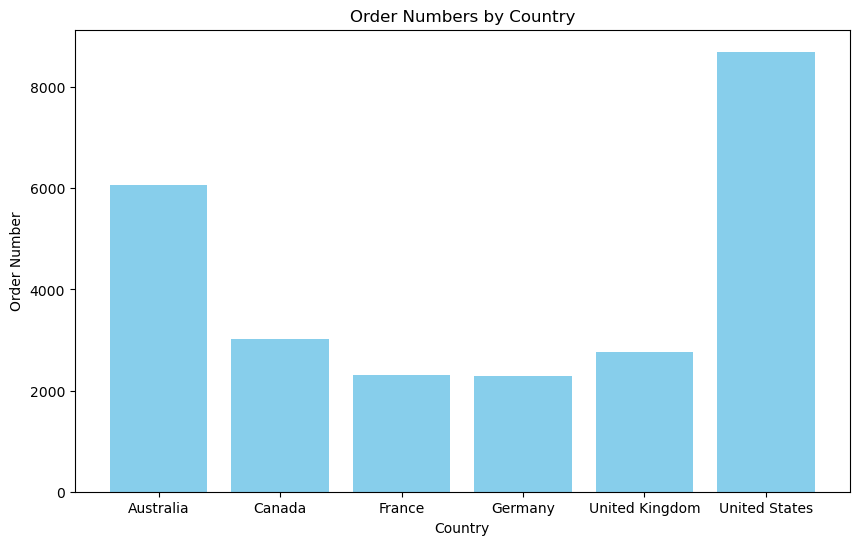

In [734]:
plt.figure(figsize=(10, 6))
plt.bar(orders_per_country['Country'], orders_per_country['OrderNumber'], color='skyblue')
plt.title('Order Numbers by Country')
plt.xlabel('Country')
plt.ylabel('Order Number')
plt.show()


prev month orders vs last month orders per product

In [735]:
# Group by product name and start of the month to calculate the number of unique orders
order_comparison_products = (
    sales_product_calender_table
    .groupby(['ProductName', 'StartofMonth'])['OrderNumber']
    .nunique()
    .reset_index()
)

# Add a column for the number of unique orders in the previous month
order_comparison_products['prev_month'] = order_comparison_products['OrderNumber'].shift(1).astype('Int64')

# Get the latest month from the calendar lookup
latest_month = calender_lookup['StartofMonth'].max()

# Filter for the latest month and include only rows where previous month's data is available
latest_month_data = (
    order_comparison_products[
        (order_comparison_products['StartofMonth'] == latest_month) & 
        (order_comparison_products['prev_month'].notnull())
    ]
)
latest_month_data


,ProductName,StartofMonth,OrderNumber,prev_month
11,AWC Logo Cap,2022-06-01,232,201
23,All-Purpose Bike Stand,2022-06-01,13,25
35,Bike Wash - Dissolver,2022-06-01,93,91
47,"Classic Vest, L",2022-06-01,21,13
59,"Classic Vest, M",2022-06-01,16,18
...,...,...,...,...
1680,"Touring-3000 Yellow, 62",2022-06-01,6,5
1692,Water Bottle - 30 oz.,2022-06-01,404,398
1704,"Women's Mountain Shorts, L",2022-06-01,31,26
1716,"Women's Mountain Shorts, M",2022-06-01,38,28


prev month revenue vs last month revenue per product

In [736]:
# Aggregate revenue by product name and month
monthly_revenue_by_product = (
    sales_product_calender_table
    .groupby(['ProductName', 'StartofMonth'])['Revenue']
    .sum()
    .reset_index()
)

# Add a column for the revenue of the previous month
monthly_revenue_by_product['prev_month'] = monthly_revenue_by_product['Revenue'].shift(1)

# Get the latest month from the calendar lookup
latest_month = calender_lookup['StartofMonth'].max()

# Filter for the latest month and include only rows where previous month's revenue is available
latest_month_revenue = (
    monthly_revenue_by_product[
        (monthly_revenue_by_product['StartofMonth'] == latest_month) & 
        (monthly_revenue_by_product['prev_month'].notnull())
    ]
)
latest_month_revenue


,ProductName,StartofMonth,Revenue,prev_month
11,AWC Logo Cap,2022-06-01,4034.88,3421.44
23,All-Purpose Bike Stand,2022-06-01,2067.00,3975.00
35,Bike Wash - Dissolver,2022-06-01,1518.45,1486.65
47,"Classic Vest, L",2022-06-01,1333.50,825.50
59,"Classic Vest, M",2022-06-01,1016.00,1143.00
...,...,...,...,...
1680,"Touring-3000 Yellow, 62",2022-06-01,4454.10,3711.75
1692,Water Bottle - 30 oz.,2022-06-01,4066.85,3902.18
1704,"Women's Mountain Shorts, L",2022-06-01,2169.69,1819.74
1716,"Women's Mountain Shorts, M",2022-06-01,2659.62,1959.72


prev month profit vs last month profit per product

In [737]:
# Calculate profit for each sale
sales_product_calender_table['Profit'] = (
    sales_product_calender_table['Revenue'] - 
    (sales_product_calender_table['ProductCost'] * sales_product_calender_table['OrderQuantity'])
)

# Aggregate profit by product name and month
monthly_profit_by_product = (
    sales_product_calender_table
    .groupby(['ProductName', 'StartofMonth'])['Profit']
    .sum()
    .reset_index()
)

# Add a column for the profit of the previous month
monthly_profit_by_product['prev_month'] = monthly_profit_by_product['Profit'].shift(1)

# Get the latest month from the calendar lookup
latest_month = calender_lookup['StartofMonth'].max()

# Filter for the latest month and include only rows where previous month's profit is available
latest_month_profit = (
    monthly_profit_by_product[
        (monthly_profit_by_product['StartofMonth'] == latest_month) & 
        (monthly_profit_by_product['prev_month'].notnull())
    ]
)
latest_month_profit


,ProductName,StartofMonth,Profit,prev_month
11,AWC Logo Cap,2022-06-01,1368.31,1160.28
23,All-Purpose Bike Stand,2022-06-01,1293.89,2488.25
35,Bike Wash - Dissolver,2022-06-01,951.18,931.26
47,"Classic Vest, L",2022-06-01,834.75,516.75
59,"Classic Vest, M",2022-06-01,636.00,715.50
...,...,...,...,...
1680,"Touring-3000 Yellow, 62",2022-06-01,1685.46,1404.55
1692,Water Bottle - 30 oz.,2022-06-01,2542.80,2439.84
1704,"Women's Mountain Shorts, L",2022-06-01,1358.11,1139.06
1716,"Women's Mountain Shorts, M",2022-06-01,1664.78,1226.68
